<a href="https://colab.research.google.com/github/KThirukkumar/freeCodeCamp-machinelearning/blob/main/Book_Recommendation/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2022-11-28 05:58:59--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  --.-KB/s    in 0.1s    

2022-11-28 05:58:59 (177 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

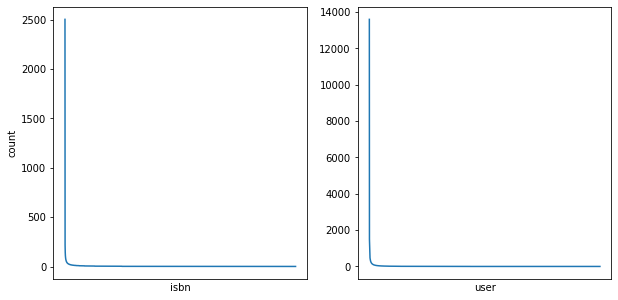

In [ ]:
#the majority of books and users have a small number of ratings
fig,axs = plt.subplots(1,2,figsize = (10,5))
axs[0].set(xlabel = 'isbn')
df_ratings.isbn.value_counts().plot(use_index = False, xticks = [], ylabel = 'count', ax = axs[0])
axs[1].set(xlabel = 'user')
df_ratings.user.value_counts().plot(use_index = False, xticks = [], ax = axs[1])

1099999 of 1149780 entries excluded


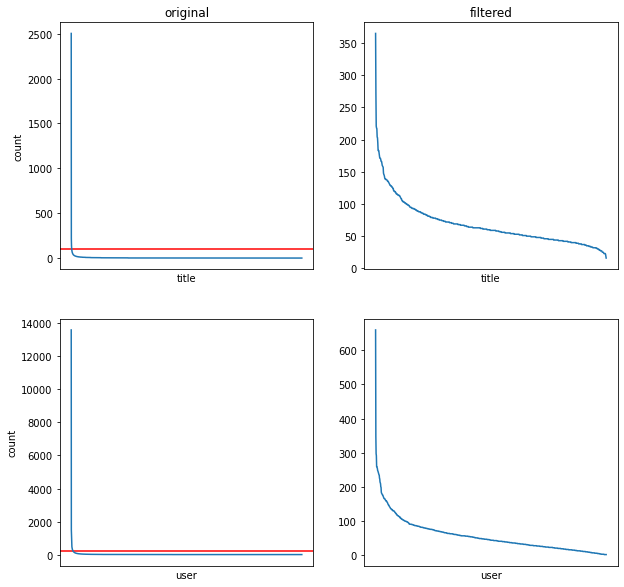

In [ ]:
#filter out low rating counts and check results. Remaining counts are < filter thresholds because the filters interact.
robust_ratings = df_ratings.loc[(~df_ratings.user.isin(df_ratings.user.value_counts().loc[lambda x: x<200].index))
                &(~df_ratings.isbn.isin(df_ratings.isbn.value_counts().loc[lambda x: x<100].index))].reset_index(drop = True)
print(df_ratings.shape[0] - robust_ratings.shape[0], 'of', df_ratings.shape[0], 'entries excluded')

fig,axs = plt.subplots(2,2, figsize = [10,10])
axs[(0,0)].axhline(y=100, color='r')
axs[(1,0)].axhline(y=200, color='r')
df_ratings.isbn.value_counts().plot(xticks = [], xlabel = 'title', ylabel = 'count', title = 'original', ax = axs[(0,0)])
axs[(1,0)].set_xlabel('user')
df_ratings.user.value_counts().plot(xticks = [], use_index = False, ylabel = 'count', ax = axs[(1,0)])
robust_ratings.isbn.value_counts().plot(xticks = [], xlabel = 'title', title = 'filtered', ax = axs[(0,1)])
axs[(1,1)].set_xlabel('user')
robust_ratings.user.value_counts().plot(xticks = [], use_index = False, ax = axs[(1,1)])

In [ ]:
#merge dataframes so we have title for each rating
book_ratings = pd.merge(robust_ratings,df_books, on = 'isbn')
#remove unneeded columns
book_ratings = book_ratings.drop(['author','isbn'], axis = 1)
print(book_ratings.shape)
book_ratings.head()

(49517, 3)


,user,rating,title
0,277427,10.0,Politically Correct Bedtime Stories: Modern Ta...
1,3363,0.0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,6.0,Politically Correct Bedtime Stories: Modern Ta...
3,12538,10.0,Politically Correct Bedtime Stories: Modern Ta...
4,13552,0.0,Politically Correct Bedtime Stories: Modern Ta...


In [ ]:
#drop duplicate book ratings (same book, different isbn) by same user
#note that THIS IS NOT THE MOST LOGICAL place (it should be done before filtering)
#or way to do this (can be done while grouping, and shouldn't arbitrarily keep the first value).
#It is only implemented here to meet the strange testing criteria
clean_ratings = book_ratings.drop_duplicates(['title','user'])
clean_ratings.shape

(49136, 3)

In [ ]:
#convert ratings to a 2d user by title matrix, with missing values (user didn't rate)
#set to 0 so user ratings for each title are all complete vectors that can be used to calculate distance
ratings2d = clean_ratings.pivot(index = 'title', columns = 'user', values = 'rating').fillna(0)
ratings2d.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#convert 2d matrix to scipy sparse matrix. This is standard practice for sklearn NN input
#and speeds up calculations
ratings_csr = csr_matrix(ratings2d.values) 
ratings_csr

<673x888 sparse matrix of type '<class 'numpy.float32'>'
	with 12419 stored elements in Compressed Sparse Row format>

In [ ]:
#set up KNN model using brute algorithm and cosine similarity between rating vectors
model = NearestNeighbors(metric = 'cosine', algorithm= 'brute')
model.fit(ratings_csr)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# function to return recommended books - this will be tested
# note that it is illogical to reverse the order of book recommendations, as the model outputs by distance (smaller is closer),
# not cosine distance (larger would closer)
def get_recommends(book = "Where the Heart Is (Oprah's Book Club (Paperback))"):
  distances, recommends = model.kneighbors(ratings2d.loc[book].values.reshape(1,-1), n_neighbors= 6)
  recommended_books = []
  book_list = []
  for i in range (0,len(recommends.flatten())):
    if i == 0:
      recommended_books.append(ratings2d.index[recommends.flatten()[i]])
    else:
      book_list.append([ratings2d.index[recommends.flatten()[len(recommends.flatten())-i]], distances.flatten()[len(recommends.flatten())-i]])
  recommended_books.append(book_list)

  return recommended_books


get_recommends()

["Where the Heart Is (Oprah's Book Club (Paperback))",
 [["I'll Be Seeing You", 0.8016211],
  ['The Weight of Water', 0.77085835],
  ['The Surgeon', 0.7699411],
  ['I Know This Much Is True', 0.7677075],
  ['The Lovely Bones: A Novel', 0.7234864]]]

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
